In [17]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

In [18]:
# -------------------------------
# Parameters
# -------------------------------
img_height, img_width = 224, 224
batch_size = 32
max_epochs = 300  # Maximum training epochs

# Adam optimizer parameters
learning_rate = 1e-4
beta_1 = 0.9
beta_2 = 0.999
epsilon = 1e-7

# Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

In [19]:
# -------------------------------
# Paths & Filter Selection
# -------------------------------
dataset_path = "/kaggle/input/new-data/Balanced_dataset_augmented_new"
filter_name = "K720_balance"  # Change filter if needed

# Define two classes: Healthy and Diseased
classes = ["healthy", "diseased"]  # Matching your folder structure

# Construct dataset paths
filter_path = os.path.join(dataset_path, filter_name)
train_dir = os.path.join(filter_path, 'train')
validation_dir = os.path.join(filter_path, 'validation')
test_dir = os.path.join(filter_path, 'test')

In [20]:
# -------------------------------
# Data Generators
# -------------------------------
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',  # Binary classification
    color_mode='rgb',  # Ensure all images are RGB
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',  # Binary classification
    color_mode='rgb',
    shuffle=False
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',  # Binary classification
    color_mode='rgb',
    shuffle=False
)

Found 2121 images belonging to 2 classes.
Found 267 images belonging to 2 classes.
Found 264 images belonging to 2 classes.


In [21]:
# -------------------------------
# Build the Xception Model
# -------------------------------
base_model = Xception(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Dropout for regularization
predictions = Dense(1, activation='sigmoid')(x)  # Single neuron for binary classification

In [22]:
# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
optimizer = Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 111, 111, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 111, 111, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 111, 111, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 109, 109, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 109, 109, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 109, 109, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 109, 109, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 109, 109, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 109, 109, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 55, 55, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 55, 55, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 20,863,529 (79.59 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [23]:
# -------------------------------
# Train the Model
# -------------------------------
history = model.fit(
    train_generator,
    epochs=max_epochs,
    validation_data=validation_generator,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/300


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


67/67 ━━━━━━━━━━━━━━━━━━━━ 29s 324ms/step - accuracy: 0.5431 - loss: 0.7153 - val_accuracy: 0.6404 - val_loss: 0.6729
Epoch 2/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 0.5739 - loss: 0.6778 - val_accuracy: 0.6330 - val_loss: 0.6588
Epoch 3/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 0.5798 - loss: 0.6809 - val_accuracy: 0.6629 - val_loss: 0.6463
Epoch 4/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 0.5862 - loss: 0.6701 - val_accuracy: 0.6742 - val_loss: 0.6349
Epoch 5/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 0.6342 - loss: 0.6441 - val_accuracy: 0.6929 - val_loss: 0.6249
Epoch 6/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 0.6290 - loss: 0.6425 - val_accuracy: 0.6891 - val_loss: 0.6158
Epoch 7/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 0.6369 - loss: 0.6316 - val_accuracy: 0.7228 - val_loss: 0.6088
Epoch 8/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 0.6574 - loss: 0.6259 - val_accuracy

In [33]:
# -------------------------------
# Evaluate the Model on Train, Validation, and Test Sets
# -------------------------------

# Evaluate on Training Set
train_loss, train_acc = model.evaluate(train_generator, verbose=1)
print("Train Accuracy: {:.2f}%".format(train_acc * 100))
print("Train Loss: {:.4f}".format(train_loss))

# Evaluate on Validation Set
val_loss, val_acc = model.evaluate(validation_generator, verbose=1)
print("Validation Accuracy: {:.2f}%".format(val_acc * 100))
print("Validation Loss: {:.4f}".format(val_loss))

# Evaluate on Test Set
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print("Test Accuracy: {:.2f}%".format(test_acc * 100))
print("Test Loss: {:.4f}".format(test_loss))

# Print summary of results
print("\n=== Model Evaluation Summary ===")
print(f"Train Accuracy:     {train_acc * 100:.2f}%")
print(f"Train Loss:         {train_loss:.4f}")
print(f"Validation Accuracy:{val_acc * 100:.2f}%")
print(f"Validation Loss:    {val_loss:.4f}")
print(f"Test Accuracy:      {test_acc * 100:.2f}%")
print(f"Test Loss:          {test_loss:.4f}")

67/67 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step - accuracy: 0.8650 - loss: 0.3562
Train Accuracy: 86.70%
Train Loss: 0.3496
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.7935 - loss: 0.4565
Validation Accuracy: 82.77%
Validation Loss: 0.4157
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.7972 - loss: 0.4399
Test Accuracy: 83.33%
Test Loss: 0.4108

=== Model Evaluation Summary ===
Train Accuracy:     86.70%
Train Loss:         0.3496
Validation Accuracy:82.77%
Validation Loss:    0.4157
Test Accuracy:      83.33%
Test Loss:          0.4108


In [34]:
# -------------------------------
# Compute Classification Metrics
# -------------------------------
test_preds = model.predict(test_generator)
y_pred = (test_preds > 0.5).astype(int).flatten()  # Convert probabilities to binary labels
y_true = test_generator.classes

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=classes))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step

Classification Report:
              precision    recall  f1-score   support

     healthy       0.84      0.84      0.84       136
    diseased       0.83      0.83      0.83       128

    accuracy                           0.83       264
   macro avg       0.83      0.83      0.83       264
weighted avg       0.83      0.83      0.83       264

Confusion Matrix:
[[114  22]
 [ 22 106]]


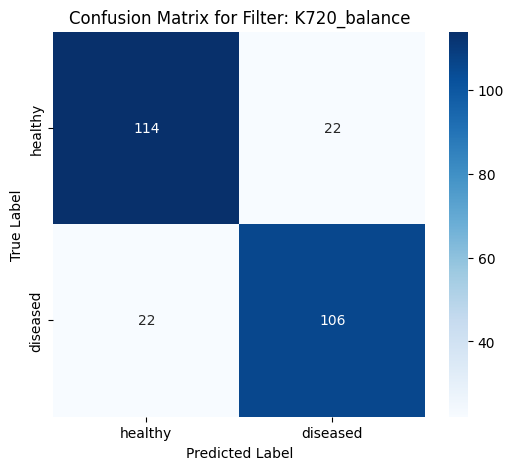

In [35]:
# -------------------------------
# Visualize Confusion Matrix
# -------------------------------
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix for Filter: {filter_name}")
plt.show()

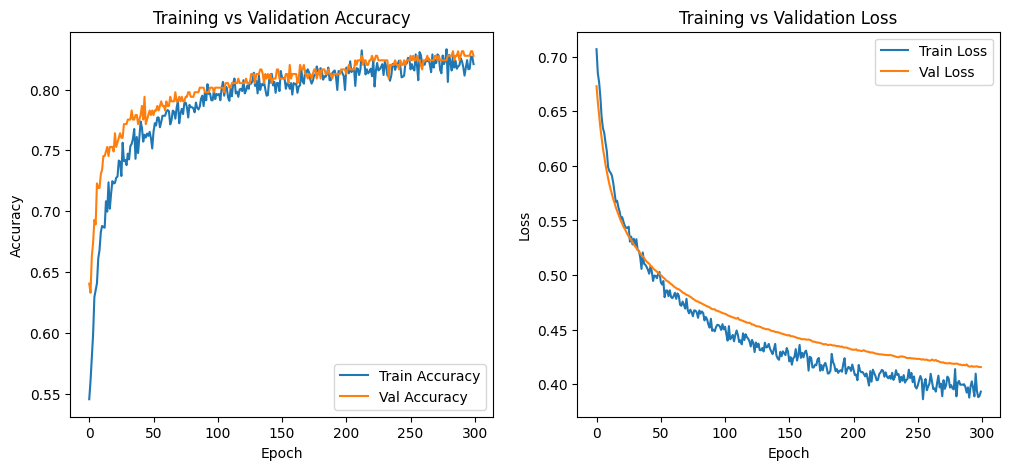

In [36]:
# -------------------------------
# Visualize Training History
# -------------------------------
plt.figure(figsize=(12,5))

# Plot Training vs Validation Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

# Plot Training vs Validation Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


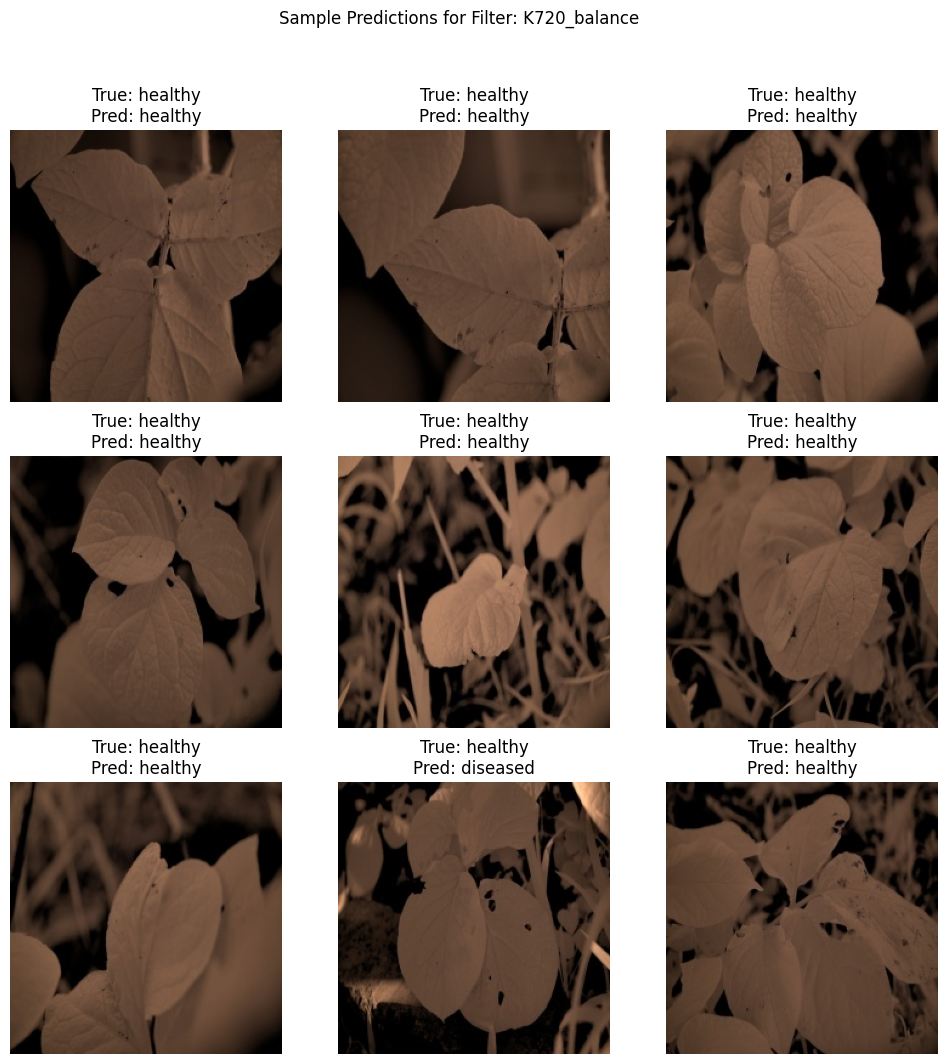

In [37]:
# -------------------------------
# Visualize Sample Predictions
# -------------------------------
test_images, test_labels = next(test_generator)
preds = model.predict(test_images)
pred_classes = (preds > 0.5).astype(int).flatten()
true_classes = test_labels.astype(int)

plt.figure(figsize=(12,12))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(test_images[i])
    plt.title(f"True: {classes[true_classes[i]]}\nPred: {classes[pred_classes[i]]}")
    plt.axis('off')
plt.suptitle(f"Sample Predictions for Filter: {filter_name}")
plt.show()

In [38]:
# Generate predictions
test_preds = model.predict(test_generator)
y_pred = np.argmax(test_preds, axis=1)  # Convert to class indices

# Get true labels from the test generator
y_true = test_generator.classes  # These are numerical labels (0 or 1)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step


In [39]:
species_true = []
species_pred = []

# Extract species names correctly from filenames
for i, filename in enumerate(test_generator.filenames):
    # Example: "diseased/Papaya_diseased/leaf_123.jpg"
    parts = filename.split('/')  
    if len(parts) >= 2:  # Ensure correct structure
        species = parts[1].split('_')[0]  # Extract 'Papaya', 'Potato', 'Tomato'
        species_true.append(species)
        species_pred.append("healthy" if y_pred[i] == 1 else "diseased")  # Get model prediction

print("Sample true species:", species_true[:10])
print("Sample predicted labels:", species_pred[:10])


Sample true species: ['Papaya', 'Papaya', 'Papaya', 'Papaya', 'Papaya', 'Papaya', 'Papaya', 'Papaya', 'Papaya', 'Papaya']
Sample predicted labels: ['diseased', 'diseased', 'diseased', 'diseased', 'diseased', 'diseased', 'diseased', 'diseased', 'diseased', 'diseased']


In [40]:
from collections import defaultdict

species_correct = defaultdict(int)
species_total = defaultdict(int)

# Count correct predictions per species
for i in range(len(species_true)):
    true_species = species_true[i]
    true_label = "healthy" if y_true[i] == 1 else "diseased"
    pred_label = species_pred[i]  # Model predicted "healthy" or "diseased"

    # Count correctly predicted cases
    if pred_label == true_label:
        species_correct[true_species] += 1
    
    species_total[true_species] += 1

# Compute accuracy per species
species_accuracy = {species: (species_correct[species] / species_total[species]) * 100 
                    for species in species_total}

# Print accuracy per plant species
print("\n=== Per-Species Accuracy ===")
for species, acc in species_accuracy.items():
    print(f"{species}: {acc:.2f}%")


=== Per-Species Accuracy ===
Papaya: 44.62%
Potato: 56.76%
Tomato: 50.00%


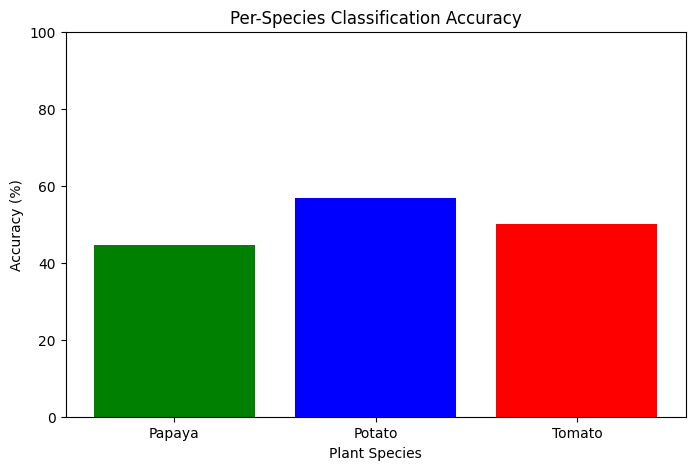

In [41]:
import matplotlib.pyplot as plt

species_list = list(species_accuracy.keys())
accuracy_list = list(species_accuracy.values())

plt.figure(figsize=(8,5))
plt.bar(species_list, accuracy_list, color=['green', 'blue', 'red'])
plt.xlabel("Plant Species")
plt.ylabel("Accuracy (%)")
plt.title("Per-Species Classification Accuracy")
plt.ylim(0, 100)
plt.show()
